
# PyTorch Visualisation

we show you how to load in data, feed it through a model we define as a subclass of nn.Module, train this model on training data, and test it on test data. To see what’s happening, we print out some statistics as the model is training to get a sense for whether training is progressing. However, we can do much better than that: PyTorch integrates with TensorBoard, a tool designed for visualizing the results of neural network training runs.

We’ll begin with similar boilerplate code as in the last session:


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Files already downloaded and verified
Files already downloaded and verified


### 1. TensorBoard setup

Now we’ll set up TensorBoard, importing `tensorboar` from `torch.util` and defining a `SummaryWriter`, our key object for writing information to TensorBoard.



In [2]:
# pip install tensorboard
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cifar10_experiment')

### 2. Writing to TensorBoard

Now let’s write an image to our TensorBoard - specifically, a grid - using `make_grid`.

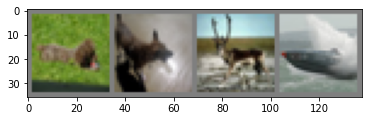

In [3]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
# helper function to show an image
# (used in the `plot_classes_preds` function below)
import matplotlib.pyplot as plt
import numpy as np
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
matplotlib_imshow(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('four_cifar10_images', img_grid)

Now running TensorBoard:
`tensorboard --logdir=runs`

### 3. Tracking model training with TensorBoard

In the previous example, we simply printed the model’s running loss every 2000 iterations. Now, we’ll instead log the running loss to TensorBoard; this is done using the add_scalar function.



In [4]:
epochs = 3

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            ####### log the running loss######
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.295
[1,  2000] loss: 2.092
[1,  3000] loss: 1.896
[1,  4000] loss: 1.751
[1,  5000] loss: 1.654
[1,  6000] loss: 1.641
[1,  7000] loss: 1.597
[1,  8000] loss: 1.556
[1,  9000] loss: 1.545
[1, 10000] loss: 1.472
[1, 11000] loss: 1.466
[1, 12000] loss: 1.472


KeyboardInterrupt: 

### 4. Inspect the model using TensorBoard
One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [5]:
writer.add_graph(net, images)
writer.close()

---

### Reference

 - [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
 - [Visualizing Models, Data, and Training with TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html#visualizing-models-data-and-training-with-tensorboard)